In [1]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Bedok'
df = df[(df.town==town.upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 1954


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127782,BEDOK,2 ROOM,535,BEDOK NTH ST 3,45.0,Improved,1986,62 years 08 months,255000.0,2.0,65.0
127783,BEDOK,3 ROOM,424,BEDOK NTH AVE 1,67.0,New Generation,1979,55 years 08 months,398000.0,11.0,65.0
127784,BEDOK,3 ROOM,423,BEDOK NTH AVE 1,81.0,New Generation,1979,55 years 08 months,420000.0,11.0,65.0
127785,BEDOK,3 ROOM,418,BEDOK NTH AVE 2,67.0,New Generation,1978,55 years 06 months,370000.0,8.0,65.0
127786,BEDOK,3 ROOM,515,BEDOK NTH AVE 2,82.0,New Generation,1979,56 years 02 months,392000.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152428,BEDOK,5 ROOM,807C,CHAI CHEE RD,113.0,Improved,2016,92 years 07 months,830000.0,2.0,76.0
152429,BEDOK,EXECUTIVE,94B,BEDOK NTH AVE 4,143.0,Apartment,1993,69 years 02 months,930000.0,11.0,76.0
152430,BEDOK,EXECUTIVE,115,BEDOK RESERVOIR RD,150.0,Maisonette,1985,61 years 06 months,855000.0,11.0,76.0
152431,BEDOK,EXECUTIVE,640,BEDOK RESERVOIR RD,144.0,Apartment,1993,69 years 08 months,770000.0,2.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (i%10==0):
      print(f"{i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
    count += 1
    errors.append(add)
print(f"{errors} detected")
dump_pkl()


longLats loaded. 1954
0 of 428
10 of 428
20 of 428
check 30 NEW UPP CHANGI RD. Singapore. confidence of 0.6
check 57 NEW UPP CHANGI RD. Singapore. confidence of 0.6
check 29 NEW UPP CHANGI RD. Singapore. confidence of 0.6
30 of 428
40 of 428
50 of 428
check 651 JLN TENAGA. Singapore. confidence of 0.6
check 647 JLN TENAGA. Singapore. confidence of 0.6
60 of 428
check 657 JLN TENAGA. Singapore. confidence of 0.6
check 648 JLN TENAGA. Singapore. confidence of 0.6
check 664 JLN DAMAI. Singapore. confidence of 0.6
80 of 428
90 of 428
100 of 428
110 of 428
check 24 NEW UPP CHANGI RD. Singapore. confidence of 0.6
120 of 428
130 of 428
check 671 JLN DAMAI. Singapore. confidence of 0.6
check 64 NEW UPP CHANGI RD. Singapore. confidence of 0.6
check 53 NEW UPP CHANGI RD. Singapore. confidence of 0.6
150 of 428
160 of 428
check 61 NEW UPP CHANGI RD. Singapore. confidence of 0.6
170 of 428
180 of 428
check 27 NEW UPP CHANGI RD. Singapore. confidence of 0.6
190 of 428
200 of 428
210 of 428
check 65

TypeError: dump_pkl() missing 1 required positional argument: 'longLats'

In [3]:
dump_pkl(longLats)

pickle dumped. 2343


In [5]:
# Errors at
# NEW UPP CHANGI RD
# JLN DAMAI
# JLN TENAGA

4

In [4]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127782,BEDOK,2 ROOM,535,BEDOK NTH ST 3,45.0,Improved,1986,62 years 08 months,255000.0,2.0,65.0
127783,BEDOK,3 ROOM,424,BEDOK NTH AVE 1,67.0,New Generation,1979,55 years 08 months,398000.0,11.0,65.0
127784,BEDOK,3 ROOM,423,BEDOK NTH AVE 1,81.0,New Generation,1979,55 years 08 months,420000.0,11.0,65.0
127785,BEDOK,3 ROOM,418,BEDOK NTH AVE 2,67.0,New Generation,1978,55 years 06 months,370000.0,8.0,65.0
127786,BEDOK,3 ROOM,515,BEDOK NTH AVE 2,82.0,New Generation,1979,56 years 02 months,392000.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152428,BEDOK,5 ROOM,807C,CHAI CHEE RD,113.0,Improved,2016,92 years 07 months,830000.0,2.0,76.0
152429,BEDOK,EXECUTIVE,94B,BEDOK NTH AVE 4,143.0,Apartment,1993,69 years 02 months,930000.0,11.0,76.0
152430,BEDOK,EXECUTIVE,115,BEDOK RESERVOIR RD,150.0,Maisonette,1985,61 years 06 months,855000.0,11.0,76.0
152431,BEDOK,EXECUTIVE,640,BEDOK RESERVOIR RD,144.0,Apartment,1993,69 years 08 months,770000.0,2.0,76.0


In [7]:
town = "Bedok"
dfL = df[(~df.street_name.str.startswith('JLN DAMAI'))&(~df.street_name.str.startswith('JLN TENAGA'))&(~df.street_name.str.startswith('NEW UPP CHANGI RD'))]
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
dfL

blk_street = dfL.block + ' ' + dfL.street_name
len(blk_street.unique())


389

In [8]:
df[(df.street_name.str.startswith('JLN DAMAI'))|(df.street_name.str.startswith('JLN TENAGA'))|(df.street_name.str.startswith('NEW UPP CHANGI RD'))].describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,94.000000,94.000000,9.400000e+01,94.000000,94.000000
mean,96.563830,1985.829787,5.351976e+05,8.095745,70.223404
std,27.713806,8.670353,1.838372e+05,4.560393,3.347778
min,60.000000,1977.000000,3.000000e+05,2.000000,65.000000
25%,65.000000,1977.000000,3.552220e+05,5.000000,67.000000
50%,95.000000,1982.000000,4.925000e+05,8.000000,71.000000
75%,120.750000,1996.000000,6.800000e+05,11.000000,73.000000
max,146.000000,1997.000000,1.030000e+06,20.000000,76.000000


In [9]:
df = pd.read_csv(f'./data/{town}_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,BEDOK,2 ROOM,535,BEDOK NTH ST 3,45.0,Improved,1986,62 years 08 months,255000.0,2.0,65.0
1,BEDOK,3 ROOM,424,BEDOK NTH AVE 1,67.0,New Generation,1979,55 years 08 months,398000.0,11.0,65.0
2,BEDOK,3 ROOM,423,BEDOK NTH AVE 1,81.0,New Generation,1979,55 years 08 months,420000.0,11.0,65.0
3,BEDOK,3 ROOM,418,BEDOK NTH AVE 2,67.0,New Generation,1978,55 years 06 months,370000.0,8.0,65.0
4,BEDOK,3 ROOM,515,BEDOK NTH AVE 2,82.0,New Generation,1979,56 years 02 months,392000.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
1240,BEDOK,5 ROOM,807C,CHAI CHEE RD,113.0,Improved,2016,92 years 07 months,830000.0,2.0,76.0
1241,BEDOK,EXECUTIVE,94B,BEDOK NTH AVE 4,143.0,Apartment,1993,69 years 02 months,930000.0,11.0,76.0
1242,BEDOK,EXECUTIVE,115,BEDOK RESERVOIR RD,150.0,Maisonette,1985,61 years 06 months,855000.0,11.0,76.0
1243,BEDOK,EXECUTIVE,640,BEDOK RESERVOIR RD,144.0,Apartment,1993,69 years 08 months,770000.0,2.0,76.0


In [10]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1245.000000,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000
mean,89.383133,1985.969478,5.069015e+05,7.385542,70.391968,103.928360,1.329837
std,24.517240,11.950690,1.709875e+05,4.248410,3.404499,0.009946,0.004609
min,45.000000,1972.000000,2.500000e+05,2.000000,65.000000,103.903889,1.318201
25%,68.000000,1978.000000,3.650000e+05,5.000000,67.000000,103.922089,1.327336
50%,87.000000,1981.000000,4.550000e+05,8.000000,70.000000,103.928212,1.330299
75%,104.000000,1987.000000,6.200000e+05,11.000000,73.000000,103.937385,1.333471
max,173.000000,2018.000000,1.110888e+06,23.000000,76.000000,103.946625,1.338117


SuggestedLRs(valley=0.0020892962347716093, slide=6.309573450380412e-07)

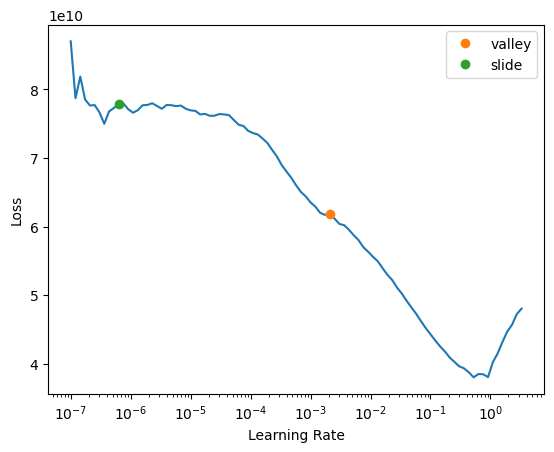

In [12]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [15]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 39981.8203125.


(#2) [1605757696.0,39981.8203125]

In [16]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*25
n2 = 3*25
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 75
10 of 75
20 of 75
30 of 75
40 of 75
50 of 75
60 of 75
70 of 75


In [17]:
import http.client, urllib.parse
import json

mrts = ["Eunos MRT", "Kembangan MRT", "Bedok MRT", "Tanah Merah MRT", "Kaki Bukit MRT", "Bedok North MRT", "Bedok Reservoir MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 2345
Eunos Station, Singapore, confidence 1
Kembangan Station, Singapore, confidence 1
Bedok Station, Singapore, confidence 1
Tanah Merah Station, Singapore, confidence 1
pickle dumped. 2349


In [21]:
mrts = ["Kaki Bukit MRT", "Bedok North MRT", "Bedok Reservoir MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)

longLats loaded. 2349
Kaki Bukit, Singapore, confidence 1
Bedok North Station Exit B, Singapore, confidence 1
Bedok Reservoir Station Exit B, Singapore, confidence 1
pickle dumped. 2352


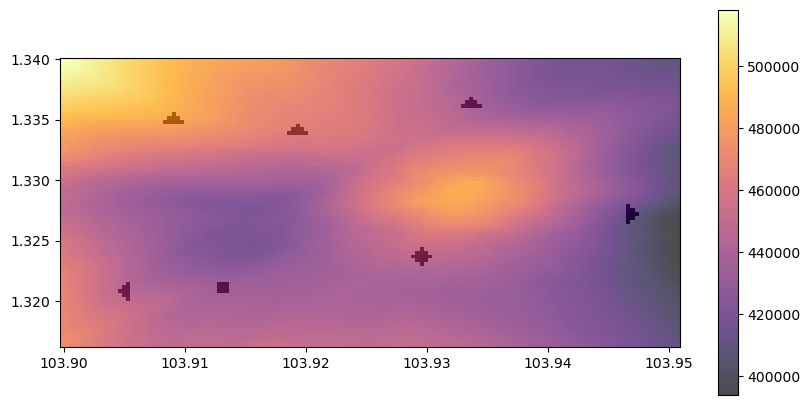

In [22]:
mrts = ["Eunos MRT", "Kembangan MRT", "Bedok MRT", "Tanah Merah MRT", "Kaki Bukit MRT", "Bedok North MRT", "Bedok Reservoir MRT"]
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

(i,j) = min_coords(*longLats[mrts[0]])
# left
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1

(i,j) = min_coords(*longLats[mrts[1]])
# square
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i-1]=1

(i,j) = min_coords(*longLats[mrts[3]])
# right
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1

for i in range(3):
  (i,j) = min_coords(*longLats[mrts[i+4]])
  # up
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1


"""
(i,j) = min_coords(*longLats[mrts[0]])
# up
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
#left
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
# down
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i-2]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+2]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i]=1

(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

In [27]:
longLeft,longRight

(103.8694542, 103.91329979999999)

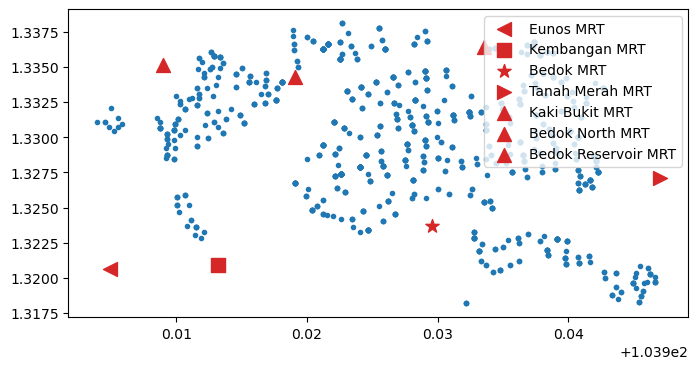

In [25]:
markers = ["<", 's', "*", '>', '^', '^', '^']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='upper right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
